## Multi-threading case

In [1]:
!pip3 install selenium==4.6.0
!pip3 install webdriver-manager==3.8.5
!pip3 install diagrams==0.23.1
!pip3 install retry==0.9.2
!pip3 install loguru==0.6.0

In [2]:
import os
import threading
import time

from selenium import webdriver
from selenium.webdriver.common.by import By

from webdriver_manager.chrome import ChromeDriverManager
from webdriver_manager.core.utils import ChromeType
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service

from IPython import display
from IPython.display import Image
from base64 import b64decode, urlsafe_b64decode, decodebytes

from retry import retry
from loguru import logger
from timeit import default_timer as timer
from datetime import timedelta

In [3]:
def saveBase64Image(img_data, filename):
    with open(f"src/{filename}", "wb") as fh:
        fh.write(b64decode(img_data))

In [4]:
logger.add("file_{time}.log", level='DEBUG')

1

In [5]:
chrome_service = Service(ChromeDriverManager().install())
logger.info("Install chrome driver")

2022-12-10 22:47:30.473 | INFO     | __main__:<module>:2 - Install chrome driver


In [6]:
# Get environment variables
IS_GITHUB_ACTION = os.getenv('IS_GITHUB_ACTION')
logger.info("Set github action env")

2022-12-10 22:47:30.480 | INFO     | __main__:<module>:3 - Set github action env


In [7]:
chrome_options = Options()
if IS_GITHUB_ACTION:
    options = [
        "--headless",
        "--disable-gpu",
        "--window-size=1920,1080",
        "--ignore-certificate-errors",
        "--disable-extensions",
        "--no-sandbox",
        "--disable-dev-shm-usage"
    ]
    user_agent = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.50 Safari/537.36'    
    chrome_options.add_argument('user-agent={0}'.format(user_agent))
    for option in options:
        chrome_options.add_argument(option)

logger.info("Set chrome driver options")

2022-12-10 22:47:30.486 | INFO     | __main__:<module>:17 - Set chrome driver options


In [8]:
logger.info("Run chrome driver")
browser = webdriver.Chrome(service=chrome_service, options=chrome_options)
browser.set_window_size(1920, 1080)
browser.get('https://www.gotokyo.org/kr/destinations/index.html')
logger.debug("Load main page done url {url}", url='https://www.gotokyo.org/kr/destinations/index.html')

2022-12-10 22:47:30.491 | INFO     | __main__:<module>:1 - Run chrome driver
2022-12-10 22:47:35.470 | DEBUG    | __main__:<module>:5 - Load main page done url https://www.gotokyo.org/kr/destinations/index.html


2022-12-10 22:47:35.477 | INFO     | __main__:<module>:1 - Crawl place list
2022-12-10 22:47:35.494 | DEBUG    | __main__:<module>:3 - Place list len: 9


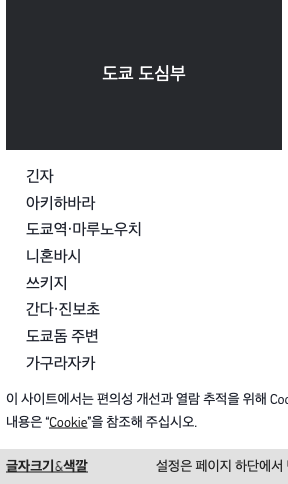

In [9]:
logger.info("Crawl place list")
placeList = browser.find_elements(By.CSS_SELECTOR, '#tmp_explore_tokyo > div > ul.mod_figure_list > li');
logger.debug("Place list len: {place_len}", place_len = len(placeList))
display.Image(b64decode(placeList[0].screenshot_as_base64))

# saveBase64Image(placeList[0].screenshot_as_base64, "test.png")

In [10]:
def getAreaListFromPlace(place):
    try:
        return [(area.text, area.get_attribute("href")) for area in place.find_elements(By.CSS_SELECTOR, "a + ul > li > a")]
    except Exception as e:
        logger.error("Cannot get place data, e: {err}", place=place, err=e)
    return []


In [11]:
logger.info("Crawl place's area data")
placeAndUrlList = [(place.find_element(By.TAG_NAME, 'a').text, 
                    place.find_element(By.TAG_NAME, 'a').get_attribute('href'),
                    getAreaListFromPlace(place)
                   ) for place in placeList]
logger.debug("Place's area data: {data}", data=placeAndUrlList)
# placeAndUrlList

2022-12-10 22:47:35.628 | INFO     | __main__:<module>:1 - Crawl place's area data
2022-12-10 22:47:37.155 | DEBUG    | __main__:<module>:6 - Place's area data: [('도쿄 도심부', 'https://www.gotokyo.org/kr/destinations/central-tokyo/index.html', [('긴자', 'https://www.gotokyo.org/kr/destinations/central-tokyo/ginza/index.html'), ('아키하바라', 'https://www.gotokyo.org/kr/destinations/central-tokyo/akihabara/index.html'), ('도쿄역・마루노우치', 'https://www.gotokyo.org/kr/destinations/central-tokyo/tokyo-station-and-marunouchi/index.html'), ('니혼바시', 'https://www.gotokyo.org/kr/destinations/central-tokyo/nihombashi/index.html'), ('쓰키지', 'https://www.gotokyo.org/kr/destinations/central-tokyo/tsukiji/index.html'), ('간다・진보초', 'https://www.gotokyo.org/kr/destinations/central-tokyo/kanda-and-jimbocho/index.html'), ('도쿄돔 주변', 'https://www.gotokyo.org/kr/destinations/central-tokyo/tokyo-dome-and-around/index.html'), ('가구라자카', 'https://www.gotokyo.org/kr/destinations/central-tokyo/kagurazaka/index.html'), ('아카사카', '

In [12]:
logger.info("Close place crawling browser")
browser.close()

2022-12-10 22:47:37.165 | INFO     | __main__:<module>:1 - Close place crawling browser


## Get area's detail info

In [13]:
def getSlideItems(slideItemList):
    logger.debug("Slider item list len {}", len(slideItemList))
    try:
        return [(slideItem.find_element(By.TAG_NAME, 'img').get_attribute('alt'), # tour content name
            slideItem.find_element(By.TAG_NAME, 'img').get_attribute('src'), # tour content img
            slideItem.find_element(By.TAG_NAME, 'a').get_attribute('href') # tour content detail link
            ) for slideItem in slideItemList]
    except Exception as e:
        logger.error("Slider item error {}", e)

In [14]:
@retry(Exception, tries=3, delay=2)
def getSlideList(browser):
    sliderCrawlResult = []
    try:
        logger.info("Remove banner to load slider list")
        browser.execute_script("document.querySelector('div.section_banner_top').remove();document.querySelector('div.left_block').remove();jQuery(window).scroll();")
        logger.info("Banner removed")
    except Exception as e:
        logger.error("Remove banner has an error {}", e)
    logger.info("Crawl slider items")
    sliderCrawlResult = [(
        slider.find_element(By.CSS_SELECTOR, 'div.slider_ttl > h2').text, #title
        getSlideItems([item for item in slider.find_elements(By.CSS_SELECTOR, 'div.slick_slide_item')]) #slider's items
        ) for slider in browser.find_elements(By.CSS_SELECTOR, 'div.section_slider_body')]
    logger.debug("Crawl slider items result {}", sliderCrawlResult)
    if sum([len(sliderItemList[1]) for sliderItemList in sliderCrawlResult]) <= 0:
        logger.info("Slider is empty, raise error");
        raise Exception('Data not found')
    return sliderCrawlResult
    
# getSlideList(browser)

In [15]:
@retry(Exception, tries=3, delay=2)
def initHeadlessBrowser():
    logger.info("Setup headless browser options")
    chrome_options = Options()
    options = [
        "--headless",
        "--disable-gpu",
        "--window-size=1920,1080",
        "--ignore-certificate-errors",
        "--disable-extensions",
        "--no-sandbox",
        "--disable-dev-shm-usage",
        "start-maximized",
        "disable-infobars"
    ]
    user_agent = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.50 Safari/537.36'    
    chrome_options.add_argument('user-agent={0}'.format(user_agent))
    for option in options:
        chrome_options.add_argument(option)
    browser = webdriver.Chrome(service=chrome_service, options=chrome_options)
    browser.set_window_size(1920, 1080)
    return browser

In [16]:
def resizeBrowserHeightAsContentFullHeight(browser):
    logger.info("Update browser's height same as content height")
    requireHeight = browser.execute_script('return document.body.parentNode.scrollHeight')
    logger.debug("Current content height {}", requireHeight)
    browser.set_window_size(1920, requireHeight)
    browser.execute_script("document.querySelector('div.section_banner_top.setheight').style.height = '464px';")
    logger.info("Manually set banner's height")
    time.sleep(2) # Because of pictures load time

In [17]:
def getAreaInfoProcess(areaName, url):
    logger.debug("Area crawling process start, url: {}", url)
    slidItemList = []
    try:
        browser = initHeadlessBrowser()
        logger.debug("Browser move to url: {}", url)
        browser.get(url)
        resizeBrowserHeightAsContentFullHeight(browser)
        saveBase64Image(browser.find_element(By.CSS_SELECTOR, "div.left_block").screenshot_as_base64, f'{areaName}.png')
        slidItemList = getSlideList(browser)
        logger.info("Get slider item done")
    except Exception as e:
        logger.error('Cannot get area info data {}', e)
    finally:
        browser.close()
    logger.info("Area crawling browser closed")
    return slidItemList

In [18]:
start = timer()
getAreaInfoProcess('ginza', 'https://www.gotokyo.org/kr/destinations/central-tokyo/ginza/index.html')
end = timer()
logger.debug("Process take time {}", timedelta(seconds=end-start))

2022-12-10 22:47:37.512 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/destinations/central-tokyo/ginza/index.html
2022-12-10 22:47:37.513 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-10 22:47:38.004 | DEBUG    | __main__:getAreaInfoProcess:6 - Browser move to url: https://www.gotokyo.org/kr/destinations/central-tokyo/ginza/index.html
2022-12-10 22:47:40.783 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-10 22:47:40.794 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 5734
2022-12-10 22:47:40.902 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-10 22:47:43.969 | ERROR    | __main__:getAreaInfoProcess:13 - Cannot get area info data [Errno 2] No such file or directory: 'src/ginza.png'
2022-12-10 22:47:44.027 | INFO     | __main_

## Single thread, Single process

In [19]:
start = timer()
areaCrawlingResult = []
for place in placeAndUrlList:
    logger.debug("place: {} len: {}", place[0], len(place[2]))
    for area in place[2]:
        logger.debug("area: {} url: {}", area[0], area[1])
        areaCrawlingResult.append(getAreaInfoProcess(area[0], area[1]))
end = timer()
logger.debug("Process take time {}", timedelta(seconds=end-start))

2022-12-10 22:47:44.037 | DEBUG    | __main__:<module>:4 - place: 도쿄 도심부 len: 11
2022-12-10 22:47:44.039 | DEBUG    | __main__:<module>:6 - area: 긴자 url: https://www.gotokyo.org/kr/destinations/central-tokyo/ginza/index.html
2022-12-10 22:47:44.040 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/destinations/central-tokyo/ginza/index.html
2022-12-10 22:47:44.041 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-10 22:47:44.528 | DEBUG    | __main__:getAreaInfoProcess:6 - Browser move to url: https://www.gotokyo.org/kr/destinations/central-tokyo/ginza/index.html
2022-12-10 22:47:46.890 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-10 22:47:46.901 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 5734
2022-12-10 22:47:47.008 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7

MaxRetryError: HTTPConnectionPool(host='localhost', port=62531): Max retries exceeded with url: /session/012d968fc093957954c20f3008673c44/window (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fab582ca160>: Failed to establish a new connection: [Errno 61] Connection refused'))

```
2022-12-10 22:26:21.084 | DEBUG    | __main__:<module>:9 - Process take time 0:12:11.764783
```

In [ ]:
areaCrawlingResult

In [ ]:
import json
with open("areaCrawlingResult.json", 'w') as outfile:
    json.dump(areaCrawlingResult, outfile)
    
with open("placeAndUrlList.json", 'w') as outfile:
    json.dump(placeAndUrlList, outfile)

In [ ]:
areaCrawlingResult[0][0]

## Single process, Multi-threading

In [21]:
start = timer()
areaCrawlingResult = []
for place in placeAndUrlList:
    threadList = []
    logger.debug("place: {} len: {}", place[0], len(place[2]))
    for area in place[2]:
        logger.debug("area: {} url: {}", area[0], area[1])
        threadList.append(threading.Thread(target=getAreaInfoProcess, args=area))
        
    [thread.start() for thread in threadList]
    [thread.join() for thread in threadList]

end = timer()
logger.debug("Process take time {}", timedelta(seconds=end-start))

2022-12-10 22:49:06.913 | DEBUG    | __main__:<module>:5 - place: 도쿄 도심부 len: 11
2022-12-10 22:49:06.927 | DEBUG    | __main__:<module>:7 - area: 긴자 url: https://www.gotokyo.org/kr/destinations/central-tokyo/ginza/index.html
2022-12-10 22:49:06.929 | DEBUG    | __main__:<module>:7 - area: 아키하바라 url: https://www.gotokyo.org/kr/destinations/central-tokyo/akihabara/index.html
2022-12-10 22:49:06.929 | DEBUG    | __main__:<module>:7 - area: 도쿄역・마루노우치 url: https://www.gotokyo.org/kr/destinations/central-tokyo/tokyo-station-and-marunouchi/index.html
2022-12-10 22:49:06.930 | DEBUG    | __main__:<module>:7 - area: 니혼바시 url: https://www.gotokyo.org/kr/destinations/central-tokyo/nihombashi/index.html
2022-12-10 22:49:06.931 | DEBUG    | __main__:<module>:7 - area: 쓰키지 url: https://www.gotokyo.org/kr/destinations/central-tokyo/tsukiji/index.html
2022-12-10 22:49:06.932 | DEBUG    | __main__:<module>:7 - area: 간다・진보초 url: https://www.gotokyo.org/kr/destinations/central-tokyo/kanda-and-jimbocho/in

2022-12-10 22:49:13.448 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 4539
2022-12-10 22:49:13.500 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 4736
2022-12-10 22:49:13.585 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-10 22:49:13.784 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-10 22:49:13.800 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-10 22:49:13.862 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 5151
2022-12-10 22:49:13.889 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-10 22:49:14.035 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 5277
2022-12-10 22:49:14.595 

2022-12-10 22:49:18.595 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-10 22:49:18.637 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 4
2022-12-10 22:49:18.658 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-10 22:49:18.666 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-10 22:49:18.667 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-10 22:49:18.835 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-10 22:49:18.854 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktrace:
0   chromedriver                        0x000000010590ff38 chromedriver + 4910904
1   chromedriver                        0x000000010588fa03 chromedriver + 4385283
2   chromedriver                        0x00000001054d4747 chromedriver + 472903

2022-12-10 22:49:19.737 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-10 22:49:19.749 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 4
2022-12-10 22:49:19.796 | INFO     | __main__:getAreaInfoProcess:16 - Area crawling browser closed
2022-12-10 22:49:19.841 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-10 22:49:19.863 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-10 22:49:20.007 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('호텔', []), ('야경', [('카레타 시오도메', 'https://www.gotokyo.org/kr/spot/441/images/441_0315_3_670x450_1.jpg', 'https://www.gotokyo.org/kr/spot/441/index.html'), ('피시 뱅크 도쿄', 'https://www.gotokyo.org/_nopub/kr/spot/1471/images/1471_3_670x450.jpg', 'javascript:void(0);'), ('루프 톱 바', 'https://www.gotokyo.org/_nopub/kr/spot/1345/images/1345_2_670x450.jpg', 'javascript:void(0);'), ('안다즈 타번', 'https://www.gotokyo.org/_nopub/en/spot/134

2022-12-10 22:49:23.094 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('아트・디자인', []), ('쇼핑', []), ('레스토랑', []), ('기타 정보', [])]
2022-12-10 22:49:23.096 | INFO     | __main__:getSlideList:17 - Slider is empty, raise error
2022-12-10 22:49:23.870 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-10 22:49:23.876 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktrace:
0   chromedriver                        0x000000010590ff38 chromedriver + 4910904
1   chromedriver                        0x000000010588fa03 chromedriver + 4385283
2   chromedriver                        0x00000001054d4747 chromedriver + 472903
3   chromedriver                        0x00000001054d8d28 chromedriver + 490792
4   chromedriver                        0x00000001054d89f6 chromedriver + 489974
5   chromedriver            

2022-12-10 22:49:25.127 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 7
2022-12-10 22:49:25.402 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 13
2022-12-10 22:49:25.884 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 6
2022-12-10 22:49:26.119 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-10 22:49:26.196 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('아트・디자인', [('뮤지엄과 마술: 온 가족이 즐기는 도쿄의 액티비티', 'https://www.gotokyo.org/en/new-and-now/new-and-trending/221003/images/221003_main_400.jpg', 'https://www.gotokyo.org/kr/new-and-now/new-and-trending/221003/topics.html'), ('음악, 아트, 식사를 오감으로 즐기는 긴자의 나이트 명소', 'https://www.gotokyo.org/en/new-and-now/new-and-trending/190311/images/190311_thum_400.jpg', 'https://www.gotokyo.org/kr/new-and-now/new-and-trending/190311/topics.html'), ('긴자 그래픽 갤러리', 'https://www.gotokyo.org/kr/spot/186/images/4447_1_670x450_1.jpg', 'https://www.gotokyo.org/kr/spot/186/index.html'), ('G

2022-12-10 22:49:28.099 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-10 22:49:28.154 | INFO     | __main__:getAreaInfoProcess:16 - Area crawling browser closed
2022-12-10 22:49:28.155 | DEBUG    | __main__:<module>:5 - place: 도쿄북부 len: 10
2022-12-10 22:49:28.156 | DEBUG    | __main__:<module>:7 - area: 이케부쿠로 url: https://www.gotokyo.org/kr/destinations/northern-tokyo/ikebukuro/index.html
2022-12-10 22:49:28.157 | DEBUG    | __main__:<module>:7 - area: 야나카・네즈 url: https://www.gotokyo.org/kr/destinations/northern-tokyo/yanaka-and-nezu/index.html
2022-12-10 22:49:28.158 | DEBUG    | __main__:<module>:7 - area: 우에노 url: https://www.gotokyo.org/kr/destinations/northern-tokyo/ueno/index.html
2022-12-10 22:49:28.159 | DEBUG    | __main__:<module>:7 - area: 스가모 url: https://www.gotokyo.org/kr/destinations/northern-tokyo/sugamo/index.html
2022-12-10 22:49:28.160 | DEBUG    | __main__:<module>:7 - area: 닛포리 url: https://www.gotokyo.org/kr/destinations/northern-tokyo

2022-12-10 22:49:35.915 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-10 22:49:35.953 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-10 22:49:35.961 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-10 22:49:36.006 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-10 22:49:36.028 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-10 22:49:36.042 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-10 22:49:36.058 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('쇼핑스트리트・상점가', []), ('공원・정원', []), ('사찰・신사', [])]
2022-12-10 22:49:36.075 | INFO     | __main__:getSlideList:17 - Slider is empty, raise error
2022-12-10 22:49:36.083 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-10 22:49:36.167 | INFO  

2022-12-10 22:49:40.962 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-10 22:49:40.970 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-10 22:49:40.975 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 7
2022-12-10 22:49:41.159 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 1
2022-12-10 22:49:41.233 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 8404
2022-12-10 22:49:41.453 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('공원・정원', []), ('종교적인 장소', []), ('아트・박물관', [('도요문고 뮤지엄', 'https://www.gotokyo.org/en/spot/862/images/5873_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/862/index.html')])]
2022-12-10 22:49:41.471 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-10 22:49:41.472 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-10 22:49:41.473 | INFO     | __main__:resizeBrowserHeightAsContentFullHei

2022-12-10 22:49:43.810 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-10 22:49:43.837 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 10
2022-12-10 22:49:44.102 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-10 22:49:44.117 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktrace:
0   chromedriver                        0x000000010590ff38 chromedriver + 4910904
1   chromedriver                        0x000000010588fa03 chromedriver + 4385283
2   chromedriver                        0x00000001054d4747 chromedriver + 472903
3   chromedriver                        0x00000001054d8d28 chromedriver + 490792
4   chromedriver                        0x00000001054d89f6 chromedriver + 489974
5   chromedriver                        0x00000001054d994e chromedriver + 493902
6   chromedriver 

2022-12-10 22:49:45.358 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-10 22:49:45.414 | INFO     | __main__:getAreaInfoProcess:16 - Area crawling browser closed
2022-12-10 22:49:45.577 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-10 22:49:45.584 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktrace:
0   chromedriver                        0x000000010590ff38 chromedriver + 4910904
1   chromedriver                        0x000000010588fa03 chromedriver + 4385283
2   chromedriver                        0x00000001054d4747 chromedriver + 472903
3   chromedriver                        0x00000001054d8d28 chromedriver + 490792
4   chromedriver                        0x00000001054d89f6 chromedriver + 489974
5   chromedriver                        0x00000001054d994e chromedriver + 49390

2022-12-10 22:49:47.255 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-10 22:49:47.263 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktrace:
0   chromedriver                        0x000000010590ff38 chromedriver + 4910904
1   chromedriver                        0x000000010588fa03 chromedriver + 4385283
2   chromedriver                        0x00000001054d4747 chromedriver + 472903
3   chromedriver                        0x00000001054d8d28 chromedriver + 490792
4   chromedriver                        0x00000001054d89f6 chromedriver + 489974
5   chromedriver                        0x00000001054d994e chromedriver + 493902
6   chromedriver                        0x000000010555afef chromedriver + 1023983
7   chromedriver                        0x000000010553f112 chromedriver + 909586
8   chromedriver         

2022-12-10 22:49:48.154 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/destinations/eastern-tokyo/fukagawa/index.html
2022-12-10 22:49:48.155 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/destinations/eastern-tokyo/kasai/index.html
2022-12-10 22:49:48.155 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-10 22:49:48.156 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-10 22:49:48.157 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-10 22:49:48.168 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-10 22:49:48.170 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-10 22:49:48.172 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-10 22:49:49.214 | DEBUG    | __main

2022-12-10 22:49:57.062 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-10 22:49:57.067 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-10 22:49:57.085 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-10 22:49:57.091 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-10 22:49:57.098 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 6
2022-12-10 22:49:57.144 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-10 22:49:57.179 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-10 22:49:57.201 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 1
2022-12-10 22:49:57.215 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-10 22:49:57.216 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('공원・정원', []), ('워터프론트', []), ('아트・박물관', [])]
2022-12-10 22:49:57.217 | INFO     | __main__:getSlideList:17 - Slider is empty, raise 

2022-12-10 22:49:58.647 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-10 22:49:58.662 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-10 22:49:58.684 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 4
2022-12-10 22:49:58.694 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('공원・정원', [('센다이보리가와 강 공원', 'https://www.gotokyo.org/kr/spot/1097/images/1097_0044_1_670x450_1.jpg', 'https://www.gotokyo.org/kr/spot/1097/index.html'), ('미나미스나 도로공원', 'https://www.gotokyo.org/en/spot/1054/images/1054_0023_2_670x450.jpg', 'https://www.gotokyo.org/kr/spot/1054/index.html'), ('요코줏켄가와 강 친수공원', 'https://www.gotokyo.org/en/spot/1099/images/1099_0857_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/1099/index.html'), ('후루이시바가와 강 친수공원', 'https://www.gotokyo.org/en/spot/1098/images/1098_0856_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/1098/index.html'), ('기바 공원', 'https://www.gotokyo.org/kr/spot/1102/images/1102_0048_1_6

2022-12-10 22:49:59.906 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-10 22:49:59.924 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-10 22:49:59.930 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktrace:
0   chromedriver                        0x000000010590ff38 chromedriver + 4910904
1   chromedriver                        0x000000010588fa03 chromedriver + 4385283
2   chromedriver                        0x00000001054d4747 chromedriver + 472903
3   chromedriver                        0x00000001054d8d28 chromedriver + 490792
4   chromedriver                        0x00000001054d89f6 chromedriver + 489974
5   chromedriver                        0x00000001054d994e chromedriver + 493902
6   chromedriver                        0x000000010555afef chromedriver + 1023983
7   chromedrive

2022-12-10 22:50:02.158 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-10 22:50:02.214 | INFO     | __main__:getAreaInfoProcess:16 - Area crawling browser closed
2022-12-10 22:50:02.215 | DEBUG    | __main__:<module>:5 - place: 도쿄서부 len: 12
2022-12-10 22:50:02.216 | DEBUG    | __main__:<module>:7 - area: 신주쿠 url: https://www.gotokyo.org/kr/destinations/western-tokyo/shinjuku/index.html
2022-12-10 22:50:02.217 | DEBUG    | __main__:<module>:7 - area: 시부야 url: https://www.gotokyo.org/kr/destinations/western-tokyo/shibuya/index.html
2022-12-10 22:50:02.218 | DEBUG    | __main__:<module>:7 - area: 하라주쿠 url: https://www.gotokyo.org/kr/destinations/western-tokyo/harajuku/index.html
2022-12-10 22:50:02.219 | DEBUG    | __main__:<module>:7 - area: 아오야마・오모테산도 url: https://www.gotokyo.org/kr/destinations/western-tokyo/aoyama-and-omotesando/index.html
2022-12-10 22:50:02.220 | DEBUG    | __main__:<module>:7 - area: 시모키타자와 url: https://www.gotokyo.org/kr/destinations/we

2022-12-10 22:50:09.424 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 5485
2022-12-10 22:50:09.567 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-10 22:50:09.631 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-10 22:50:10.237 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-10 22:50:10.439 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 5681
2022-12-10 22:50:10.481 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 7493
2022-12-10 22:50:10.508 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-10 22:50:10.536 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as co

2022-12-10 22:50:14.985 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-10 22:50:15.015 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 1
2022-12-10 22:50:15.425 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-10 22:50:15.467 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 6519
2022-12-10 22:50:15.478 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-10 22:50:15.481 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-10 22:50:15.551 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 6
2022-12-10 22:50:15.560 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-10 22:50:15.564 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-10 22:50:15.610 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-10 22:50:15.758 | INFO     | __main__:resizeBrowse

2022-12-10 22:50:21.122 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-10 22:50:21.150 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-10 22:50:21.264 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-10 22:50:21.274 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-10 22:50:21.291 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-10 22:50:21.292 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-10 22:50:21.366 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-10 22:50:21.411 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-10 22:50:21.476 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-10 22:50:21.485 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-10 22:50:21.890 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-10 22:50:22.106 | DEBUG    | __m

2022-12-10 22:50:24.736 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-10 22:50:24.754 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 5
2022-12-10 22:50:24.941 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-10 22:50:24.945 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktrace:
0   chromedriver                        0x000000010590ff38 chromedriver + 4910904
1   chromedriver                        0x000000010588fa03 chromedriver + 4385283
2   chromedriver                        0x00000001054d4747 chromedriver + 472903
3   chromedriver                        0x00000001054d8d28 chromedriver + 490792
4   chromedriver                        0x00000001054d89f6 chromedriver + 489974
5   chromedriver                        0x00000001054d994e chromedriver + 493902
6   chromedriver  

2022-12-10 22:50:26.700 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-10 22:50:26.756 | INFO     | __main__:getAreaInfoProcess:16 - Area crawling browser closed
2022-12-10 22:50:26.758 | DEBUG    | __main__:<module>:5 - place: 도쿄남부 len: 10
2022-12-10 22:50:26.758 | DEBUG    | __main__:<module>:7 - area: 오다이바 url: https://www.gotokyo.org/kr/destinations/southern-tokyo/odaiba/index.html
2022-12-10 22:50:26.759 | DEBUG    | __main__:<module>:7 - area: 시나가와・덴노즈 url: https://www.gotokyo.org/kr/destinations/southern-tokyo/shinagawa-and-tennozu/index.html
2022-12-10 22:50:26.760 | DEBUG    | __main__:<module>:7 - area: 나카메구로 url: https://www.gotokyo.org/kr/destinations/southern-tokyo/nakameguro/index.html
2022-12-10 22:50:26.761 | DEBUG    | __main__:<module>:7 - area: 롯폰기 url: https://www.gotokyo.org/kr/destinations/southern-tokyo/roppongi/index.html
2022-12-10 22:50:26.762 | DEBUG    | __main__:<module>:7 - area: 아자부주반 url: https://www.gotokyo.org/kr/destination

2022-12-10 22:50:33.067 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-10 22:50:33.068 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 12164
2022-12-10 22:50:33.578 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-10 22:50:33.621 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-10 22:50:34.067 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-10 22:50:34.157 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 6438
2022-12-10 22:50:34.526 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 6312
2022-12-10 22:50:34.777 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-10 22:50:34.789 | INFO     | __main

2022-12-10 22:50:38.206 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-10 22:50:38.250 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-10 22:50:38.251 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-10 22:50:38.346 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-10 22:50:38.366 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-10 22:50:38.400 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-10 22:50:38.402 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-10 22:50:38.415 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-10 22:50:38.459 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-10 22:50:38.563 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-10 22:50:38.564 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('온천', []), ('음식', [])]
2022-12-10 22:50:38.567 | INFO     

2022-12-10 22:50:41.214 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-10 22:50:41.235 | INFO     | __main__:getAreaInfoProcess:16 - Area crawling browser closed
2022-12-10 22:50:41.261 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-10 22:50:41.271 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 5
2022-12-10 22:50:41.308 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 6
2022-12-10 22:50:41.606 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-10 22:50:41.620 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-10 22:50:41.622 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-10 22:50:41.663 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-10 22:50:41.691 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-10 22:50:41.716 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-10 22:50:41.744 | DEBUG   

2022-12-10 22:50:42.348 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-10 22:50:42.372 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 5
2022-12-10 22:50:42.383 | INFO     | __main__:getAreaInfoProcess:16 - Area crawling browser closed
2022-12-10 22:50:42.555 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-10 22:50:42.593 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 6
2022-12-10 22:50:42.689 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 4
2022-12-10 22:50:42.842 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('아트・디자인', [('마쓰오카 미술관', 'https://www.gotokyo.org/kr/spot/674/images/674_main_670_450.jpg', 'https://www.gotokyo.org/kr/spot/674/index.html'), ('도쿄도 정원 미술관', 'https://www.gotokyo.org/en/spot/121/images/4405_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/121/index.html'), ('스기노 학원 의상박물관', 'https://www.gotokyo.org/en/spot/1245/images/1245_0902_1_670x450.jpg', 'https://www.goto

2022-12-10 22:50:43.983 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 5
2022-12-10 22:50:44.155 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 4
2022-12-10 22:50:44.294 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-10 22:50:44.392 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('아트・디자인', [('모리아츠센터 갤러리', 'https://www.gotokyo.org/kr/spot/672/images/5827_1_670x450_3.jpg', 'https://www.gotokyo.org/kr/spot/672/index.html'), ('도쿄의 여름밤을 연출하는 썸머 일루미네이션', 'https://www.gotokyo.org/en/new-and-now/new-and-trending/190610/images/190610_thum_400.jpg', 'https://www.gotokyo.org/kr/new-and-now/new-and-trending/190610/topics.html'), ('모리 미술관', 'https://www.gotokyo.org/en/spot/37/images/37_0613_4_670x450.jpg', 'https://www.gotokyo.org/kr/spot/37/index.html'), ('도쿄 미드타운', 'https://www.gotokyo.org/en/spot/8/images/8_0101_4_670x450.jpg', 'https://www.gotokyo.org/kr/spot/8/index.html'), ('기쿠치 히로미 기념 도모 미술관', 'https://www.gotokyo.org/en

2022-12-10 22:50:44.506 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-10 22:50:44.508 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-10 22:50:45.406 | DEBUG    | __main__:getAreaInfoProcess:6 - Browser move to url: https://www.gotokyo.org/kr/destinations/izu-and-ogasawara-islands/mikurajima-island/index.html
2022-12-10 22:50:45.407 | DEBUG    | __main__:getAreaInfoProcess:6 - Browser move to url: https://www.gotokyo.org/kr/destinations/izu-and-ogasawara-islands/oshima-island/index.html
2022-12-10 22:50:45.913 | DEBUG    | __main__:getAreaInfoProcess:6 - Browser move to url: https://www.gotokyo.org/kr/destinations/izu-and-ogasawara-islands/hahajima-island/index.html
2022-12-10 22:50:45.940 | DEBUG    | __main__:getAreaInfoProcess:6 - Browser move to url: https://www.gotokyo.org/kr/destinations/izu-and-ogasawara-islands/chichijima-island/index.html
2022-12-10 22:50:45.957 | DEBUG    | __main__:getAreaInfoProcess

2022-12-10 22:50:53.614 | INFO     | __main__:getSlideList:17 - Slider is empty, raise error
2022-12-10 22:50:53.965 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-10 22:50:53.974 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-10 22:50:53.976 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-10 22:50:54.238 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-10 22:50:54.258 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-10 22:50:54.344 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-10 22:50:54.344 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-10 22:50:54.345 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-10 22:50:54.365 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-10 22:50:54.368 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-10 22:50:54.369 | INFO     | __main__:

2022-12-10 22:50:55.666 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 1
2022-12-10 22:50:55.678 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-10 22:50:55.704 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('해변', [('호라이네 해안', 'https://www.gotokyo.org/kr/spot/795/images/4545_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/795/index.html'), ('미유키노하마(하하지마 섬) 해양공원', 'https://www.gotokyo.org/kr/spot/537/images/5719_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/537/index.html')]), ('산', [('고후지산', 'https://www.gotokyo.org/en/spot/263/images/4469_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/263/index.html'), ('지부사야마 산(하하지마 섬)', 'https://www.gotokyo.org/en/spot/248/images/248_0198_4_670x450.jpg', 'https://www.gotokyo.org/kr/spot/248/index.html')])]
2022-12-10 22:50:55.712 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-10 22:50:55.744 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 1
2022-12-1

2022-12-10 22:50:56.258 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-10 22:50:56.338 | INFO     | __main__:getAreaInfoProcess:16 - Area crawling browser closed
2022-12-10 22:50:56.369 | INFO     | __main__:getAreaInfoProcess:16 - Area crawling browser closed
2022-12-10 22:50:56.395 | INFO     | __main__:getAreaInfoProcess:16 - Area crawling browser closed
2022-12-10 22:50:56.411 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('아웃도어', [('오가미야마 공원', 'https://www.gotokyo.org/en/spot/957/images/957_0558_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/957/index.html'), ('주오잔 산(지치시마 섬)', 'https://www.gotokyo.org/en/spot/959/images/959_0559_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/959/index.html'), ('고미나토 해안(지치지마 섬)', 'https://www.gotokyo.org/en/spot/247/images/247_0197_5_670x450.jpg', 'https://www.gotokyo.org/kr/spot/247/index.html'), ('지히로이와(하트 바위)', 'https://www.gotokyo.org/kr/spot/681/images/681_0745_1_670x450.jpg', 'https://www.g

2022-12-10 22:50:57.925 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/destinations/outlying-area/mt-takao-and-around/index.html
2022-12-10 22:50:57.925 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/destinations/outlying-area/okutama-and-around/index.html
2022-12-10 22:50:57.926 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-10 22:50:57.936 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-10 22:50:57.939 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-10 22:50:57.940 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-10 22:50:57.948 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-10 22:50:57.950 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-10 22:50:57

2022-12-10 22:51:07.212 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-10 22:51:07.221 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 5
2022-12-10 22:51:07.268 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-10 22:51:07.418 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-10 22:51:07.465 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-10 22:51:07.631 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 13
2022-12-10 22:51:07.662 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-10 22:51:07.691 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-10 22:51:07.695 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-10 22:51:07.719 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('공원・정원', []), ('아트・박물관', [('하치오지시 유메미술관', 'https://www.gotokyo.org/en/spot/857/images/5868_1_670x450.jpg', 'https://www.gotokyo.org

2022-12-10 22:51:09.061 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-10 22:51:09.124 | INFO     | __main__:getAreaInfoProcess:16 - Area crawling browser closed
2022-12-10 22:51:09.216 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('아웃도어', []), ('산', [('도쿄도 히노하라 도민의 숲', 'https://www.gotokyo.org/en/spot/270/images/270_0212_4_670x450.jpg', 'https://www.gotokyo.org/kr/spot/270/index.html'), ('고젠야마', 'https://www.gotokyo.org/en/spot/953/images/953_0555_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/953/index.html'), ('오다케산', 'https://www.gotokyo.org/en/spot/926/images/926_0540_5_670x450.jpg', 'https://www.gotokyo.org/kr/spot/926/index.html'), ('우스키야마 산', 'https://www.gotokyo.org/en/spot/1131/images/1131_0851_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/1131/index.html'), ('마즈카리야마 산', 'https://www.gotokyo.org/en/spot/1205/images/1205_0883_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/1205/index.html'), ('아지로벤텐산 공원', 'https://www.got

2022-12-10 22:51:10.776 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-10 22:51:10.831 | INFO     | __main__:getAreaInfoProcess:16 - Area crawling browser closed
2022-12-10 22:51:11.388 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-10 22:51:11.392 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktrace:
0   chromedriver                        0x000000010590ff38 chromedriver + 4910904
1   chromedriver                        0x000000010588fa03 chromedriver + 4385283
2   chromedriver                        0x00000001054d4747 chromedriver + 472903
3   chromedriver                        0x00000001054d8d28 chromedriver + 490792
4   chromedriver                        0x00000001054d89f6 chromedriver + 489974
5   chromedriver                        0x00000001054d994e chromedriver + 49390

2022-12-10 22:51:13.330 | DEBUG    | __main__:getAreaInfoProcess:6 - Browser move to url: https://www.gotokyo.org/kr/destinations/beyond-tokyo/tokyo-disney.html
2022-12-10 22:51:13.355 | DEBUG    | __main__:getAreaInfoProcess:6 - Browser move to url: https://www.gotokyo.org/kr/destinations/beyond-tokyo/yokohama.html
2022-12-10 22:51:13.389 | DEBUG    | __main__:getAreaInfoProcess:6 - Browser move to url: https://www.gotokyo.org/kr/destinations/beyond-tokyo/hakone.html
2022-12-10 22:51:13.433 | DEBUG    | __main__:getAreaInfoProcess:6 - Browser move to url: https://www.gotokyo.org/kr/destinations/beyond-tokyo/nikko.html
2022-12-10 22:51:13.456 | DEBUG    | __main__:getAreaInfoProcess:6 - Browser move to url: https://www.gotokyo.org/kr/destinations/beyond-tokyo/kamakura.html
2022-12-10 22:51:13.491 | DEBUG    | __main__:getAreaInfoProcess:6 - Browser move to url: https://www.gotokyo.org/kr/destinations/beyond-tokyo/karuizawa.html
2022-12-10 22:51:13.503 | DEBUG    | __main__:getAreaInfoP

2022-12-10 22:51:19.851 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result []
2022-12-10 22:51:19.852 | INFO     | __main__:getSlideList:17 - Slider is empty, raise error
2022-12-10 22:51:20.106 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-10 22:51:20.114 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktrace:
0   chromedriver                        0x000000010590ff38 chromedriver + 4910904
1   chromedriver                        0x000000010588fa03 chromedriver + 4385283
2   chromedriver                        0x00000001054d4747 chromedriver + 472903
3   chromedriver                        0x00000001054d8d28 chromedriver + 490792
4   chromedriver                        0x00000001054d89f6 chromedriver + 489974
5   chromedriver                        0x00000001054d994e chromedriver + 493902
6 

2022-12-10 22:51:20.995 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-10 22:51:21.000 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result []
2022-12-10 22:51:21.001 | INFO     | __main__:getSlideList:17 - Slider is empty, raise error
2022-12-10 22:51:21.489 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-10 22:51:21.493 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktrace:
0   chromedriver                        0x000000010590ff38 chromedriver + 4910904
1   chromedriver                        0x000000010588fa03 chromedriver + 4385283
2   chromedriver                        0x00000001054d4747 chromedriver + 472903
3   chromedriver                        0x00000001054d8d28 chromedriver + 490792
4   chromedriver                        0x00000001054d89f6 chromedriver + 489974


2022-12-10 22:51:21.507 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-10 22:51:21.509 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result []
2022-12-10 22:51:21.510 | INFO     | __main__:getSlideList:17 - Slider is empty, raise error
2022-12-10 22:51:21.511 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result []
2022-12-10 22:51:21.512 | INFO     | __main__:getSlideList:17 - Slider is empty, raise error
2022-12-10 22:51:21.512 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result []
2022-12-10 22:51:21.513 | INFO     | __main__:getSlideList:17 - Slider is empty, raise error
2022-12-10 22:51:21.854 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-10 22:51:21.861 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktrace:
0   chromedriver                   

2022-12-10 22:51:22.928 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktrace:
0   chromedriver                        0x000000010590ff38 chromedriver + 4910904
1   chromedriver                        0x000000010588fa03 chromedriver + 4385283
2   chromedriver                        0x00000001054d4747 chromedriver + 472903
3   chromedriver                        0x00000001054d8d28 chromedriver + 490792
4   chromedriver                        0x00000001054d89f6 chromedriver + 489974
5   chromedriver                        0x00000001054d994e chromedriver + 493902
6   chromedriver                        0x000000010555afef chromedriver + 1023983
7   chromedriver                        0x000000010553f112 chromedriver + 909586
8   chromedriver                        0x000000010555a28e chromedriver + 1020558
9   chromedriver                        

2022-12-10 22:51:23.519 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktrace:
0   chromedriver                        0x000000010590ff38 chromedriver + 4910904
1   chromedriver                        0x000000010588fa03 chromedriver + 4385283
2   chromedriver                        0x00000001054d4747 chromedriver + 472903
3   chromedriver                        0x00000001054d8d28 chromedriver + 490792
4   chromedriver                        0x00000001054d89f6 chromedriver + 489974
5   chromedriver                        0x00000001054d994e chromedriver + 493902
6   chromedriver                        0x000000010555afef chromedriver + 1023983
7   chromedriver                        0x000000010553f112 chromedriver + 909586
8   chromedriver                        0x000000010555a28e chromedriver + 1020558
9   chromedriver                        

2022-12-10 22:51:23.943 | INFO     | __main__:getAreaInfoProcess:16 - Area crawling browser closed
2022-12-10 22:51:23.946 | DEBUG    | __main__:<module>:14 - Process take time 0:02:17.029693


```
2022-12-10 22:51:23.946 | DEBUG    | __main__:<module>:14 - Process take time 0:02:17.029693
```

## Multi-process, 